In [1]:
import os
import cv2
import random
import seaborn

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from modelLoader import diagnosticModel # Clase para instanciar modelos de diagnóstico.

In [2]:
def leerImagenes(path, files, toRead, label, MAX_IM = 250):

    shape = (256, 256)

    im_file = [random.choice(toRead) for i in range(0, MAX_IM)]
    im = [cv2.imread(path + files[im_file[i]]) for i in range(0, len(im_file))]
    im = [cv2.cvtColor(cv2.resize(i, shape), cv2.COLOR_BGR2GRAY) for i in im] # Resize y blanco/negro.

    print("listo")

    return [[i/np.max(i), label] for i in im]

def instanciaModelo(PATH):

    return diagnosticModel(PATH)

In [3]:
PATH_CSV = 'C:/Users/abcar/Desktop/casi TODO/ESCUELA/INTERNADO/Resultados/VGG16/Fondo/fundusDiag/full_df.csv'
df = pd.read_csv(PATH_CSV)

dic = {'N' : [1, 0, 0, 0, 0],
       'D' : [0, 1, 0, 0, 0],
       'G' : [0, 0, 1, 0, 0],
       'C' : [0, 0, 0, 1, 0],
       'M' : [0, 0, 0, 0, 1]}

files = df['filename'].to_list()
labeldf = [i[2] for i in df['labels'].to_list()]

label = [dic[i] for i in labeldf if i == 'N' or i == 'D' or i == 'G' or i == 'C' or i == 'M'] # Etiquetas buenas.

normal = [i for i in range(0, len(labeldf)) if labeldf[i] == 'N']
diabetes = [i for i in range(0, len(labeldf)) if labeldf[i] == 'D']
glaucoma = [i for i in range(0, len(labeldf)) if labeldf[i] == 'G']
cataratas = [i for i in range(0, len(labeldf)) if labeldf[i] == 'C']
miopia = [i for i in range(0, len(labeldf)) if labeldf[i] == 'M']

print(len(normal), len(diabetes), len(glaucoma), len(cataratas), len(miopia))

2873 1608 284 293 232


In [4]:
PATH_DATASET = 'C:/Users/abcar/Desktop/casi TODO/ESCUELA/INTERNADO/Resultados/VGG16/Fondo/fundusDiag/dataset256/'

leerImagenes(PATH_DATASET, files, normal, 1)

labels = [[1, 0, 0, 0, 0],
          [0, 1, 0, 0, 0],
          [0, 0, 1, 0, 0],
          [0, 0, 0, 1, 0],
          [0, 0, 0, 0, 1]]

toread = [normal, diabetes, glaucoma, cataratas, miopia]

data = [leerImagenes(PATH_DATASET, files, toread[i], labels[i]) for i in range(0, len(toread))] # Imágenes y labels.

print("Shape de los datos {}".format(np.shape(data)))

dataset = data[0]

for i in range(1, len(data)):

    dataset = np.concatenate((dataset, data[i]), axis = 0)

dataset = shuffle(dataset)
im, labels = [dataset[i][0] for i in range(0, len(dataset))], [dataset[i][1] for i in range(0, len(dataset))]

print(np.shape(im))

listo
listo
listo
listo
listo
listo
Shape de los datos (5, 250, 2)


c:\Users\abcar\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(1250, 256, 256)


In [5]:
PATH_T01_MODELOS = 'C:/Users/abcar/Desktop/casi TODO/ESCUELA/INTERNADO/Resultados/VGG16/Fondo/fundus lr_001 GPU/Modelos/modelo001_8.tflite'
modelos_01 = instanciaModelo(PATH_T01_MODELOS)

true = np.argmax(labels, axis = 1)
pred_labels = np.array([list(modelos_01.predict(im[i])) for i in range(0, len(im))])
pred = np.argmax(pred_labels, axis = 1)
true_labels = np.array([list(i) for i in labels])

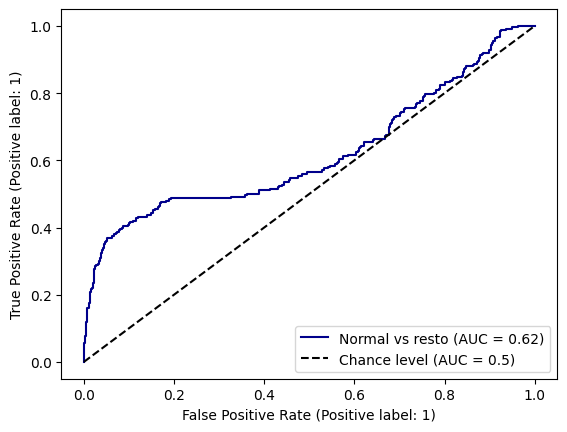

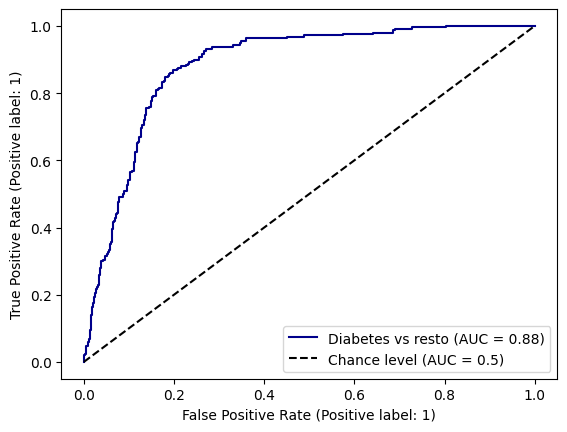

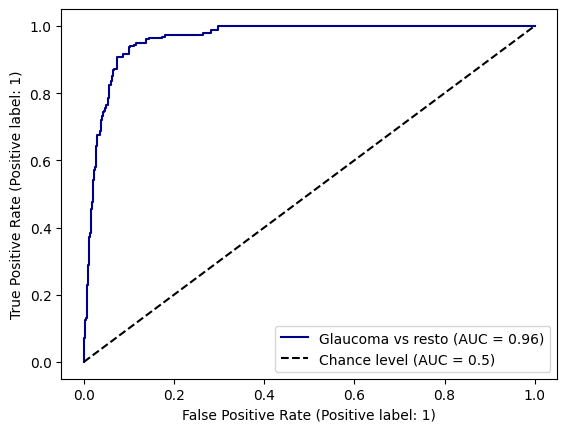

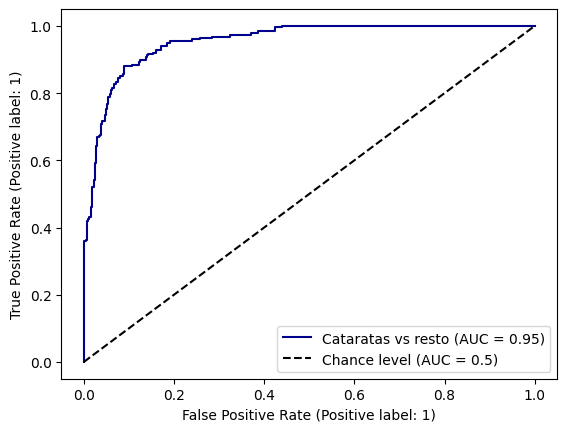

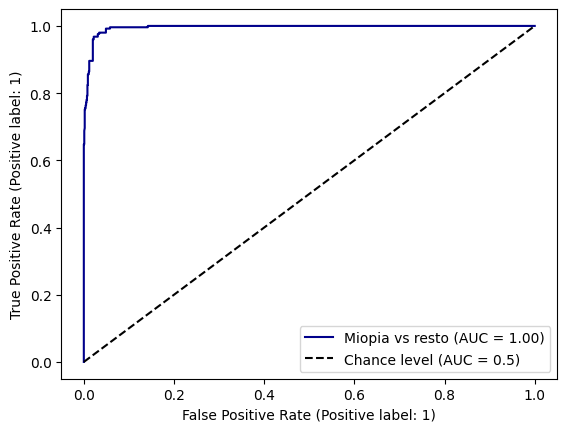

In [6]:
from sklearn.metrics import RocCurveDisplay

labels_cm = ['Normal', 'Diabetes', 'Glaucoma', 'Cataratas', 'Miopia']

for i in range(0, len(labels_cm)):

    RocCurveDisplay.from_predictions(

        true_labels[:, i],
        pred_labels[:, i],
        name =f"{labels_cm[i]} vs resto",
        color = "darkblue",
        plot_chance_level=True,
    )

Accuracy:  0.7024
TPR:  0.953
FNR:  0.047
TNR:  0.312
FPR:  0.688
F1Score:  0.6960297009587932
Precision:  0.8471111
Recall:  0.953
Accuracy (calculada):  0.8248


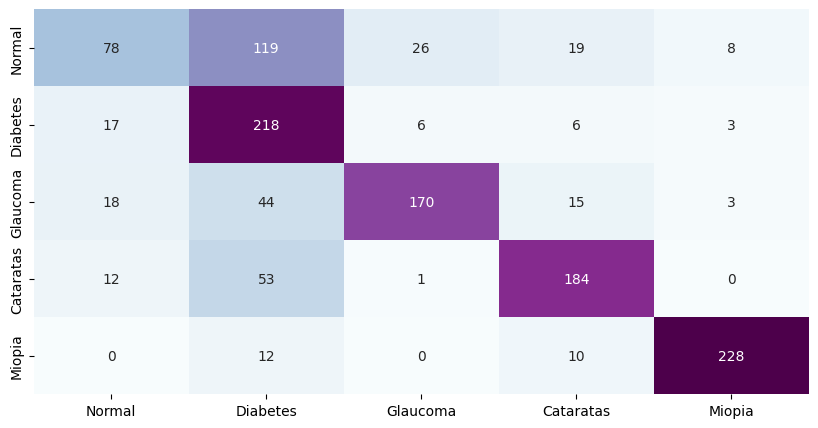

In [7]:
cm = confusion_matrix(true, pred)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
seaborn.heatmap(cm,  xticklabels = labels_cm, yticklabels = labels_cm, annot = True, cbar = False, fmt = 'g', cmap = 'BuPu')

m = tf.keras.metrics.Accuracy()
m.update_state(true, pred)
print("Accuracy: ", m.result().numpy())

fn, tn = tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives()
fp, tp = tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives()

fn.update_state(true, pred)
tn.update_state(true, pred)
fp.update_state(true, pred)
tp.update_state(true, pred)

fn_val, tn_val = fn.result().numpy(), tn.result().numpy()
fp_val, tp_val = fp.result().numpy(), tp.result().numpy()

tpr, fnr = tp_val/(tp_val + fn_val), fn_val/(tp_val + fn_val)
tnr, fpr = tn_val/(tn_val + fp_val), fp_val/(tn_val + fp_val)

print("TPR: ", tpr)
print("FNR: ", fnr)
print("TNR: ", tnr)
print("FPR: ", fpr)

precision = tp_val/(tp_val + fp_val)
recall = tp_val/(tp_val + fn_val)
accuracy = (tp_val + tn_val)/(tp_val + tn_val + fp_val + fn_val)

print("F1Score: ", f1_score(true, pred, average = 'weighted'))

print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy (calculada): ", accuracy)